# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [1]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Mounted at /content/gdrive
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports

In [3]:
!pip install wntr
%matplotlib inline
import wntr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

     |████████████████████████████████| 4.2 MB 19.9 MB/s 


In [72]:
import utils
from utils.Network import WDN
from utils.Dataloader import Dataloader

# Attention: Run twice for real reload effect
import importlib
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)

<module 'utils.Dataloader' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/utils/Dataloader.py'>

## Main

### Testing

In [90]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)"):
  plt.figure()
  ax = df.plot()
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  plt.legend(loc = "upper right")
  plt.show()

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


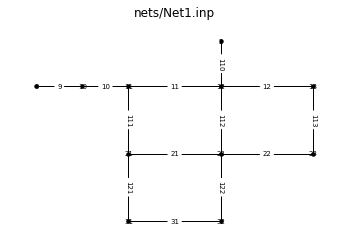

In [5]:
wdn = WDN("nets/Net1.inp", ['11','12','13','21','22','23','31','32'])
wdn.show()

In [73]:
p = wdn.simulate(12*30*24)
data = Dataloader(p, wdn.important_nodes)

<Figure size 432x288 with 0 Axes>

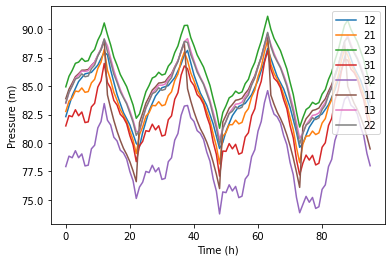

In [91]:
plot(data.get_nodes()[:4*24])

<Figure size 432x288 with 0 Axes>

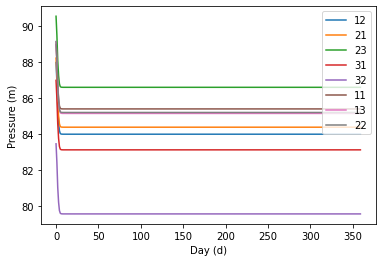

In [75]:
plot(data.get_days_at_hour(12), xlabel="Day (d)")

<Figure size 432x288 with 0 Axes>

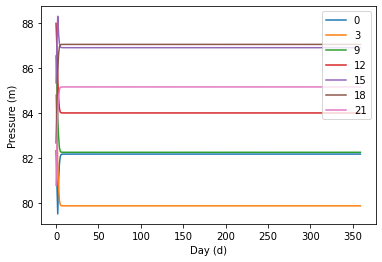

In [76]:
plot(data.get_days_at_hours('12', hours=[0, 3, 9, 12, 15, 18, 21]), xlabel="Day (d)")

In [101]:
p_leak = wdn.simulate(30*24, [('11', 0.05, 10*24+3, 10*24+21)])
data_leak = Dataloader(p_leak, wdn.important_nodes)

/usr/local/lib/python3.7/dist-packages/wntr/sim/hydraulics.py:272: UserWarning: Pump 9 has exceeded its maximum flow.
  warnings.warn('Pump ' + name + ' has exceeded its maximum flow.')


<Figure size 432x288 with 0 Axes>

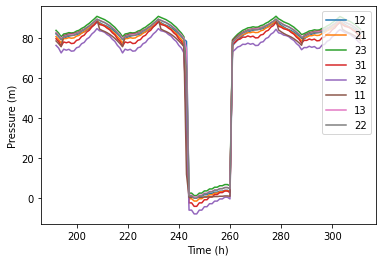

In [102]:
plot(data_leak.get_nodes()[8*24:13*24])

<Figure size 432x288 with 0 Axes>

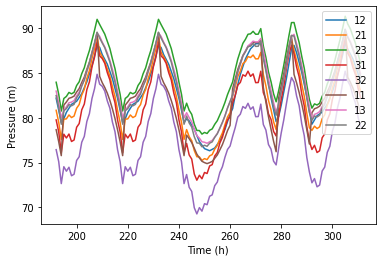

In [112]:
p_leak = wdn.simulate(30*24, [('11', 0.0018, 10*24+3, 10*24+21)])
data_leak = Dataloader(p_leak, wdn.important_nodes)
plot(data_leak.get_nodes()[8*24:13*24])

<Figure size 432x288 with 0 Axes>

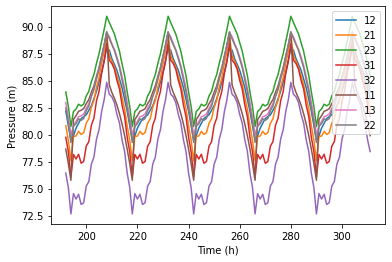

In [113]:
p_no_leak = wdn.simulate(30*24)
data_no_leak = Dataloader(p_no_leak, wdn.important_nodes)
plot(data_no_leak.get_nodes()[8*24:13*24])

<Figure size 432x288 with 0 Axes>

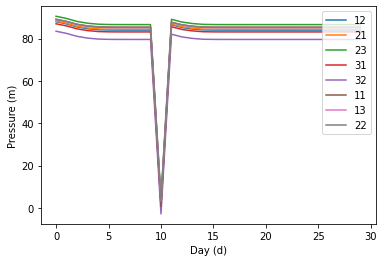

In [97]:
plot(data_leak.get_days_at_hour(12)[:30], xlabel="Day (d)")

<Figure size 432x288 with 0 Axes>

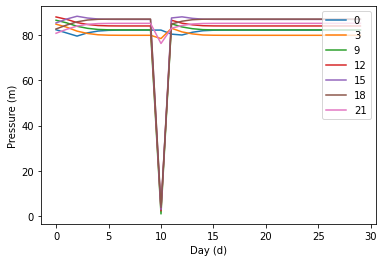

In [99]:
plot(data_leak.get_days_at_hours('12', hours=[0, 3, 9, 12, 15, 18, 21])[:30], xlabel="Day (d)")